## Data Splitting

In [1]:
import os
import myutils

path2data = "../../../data"
sub_folder_jpg = "hmdb51_jpg"
path2ajpgs = os.path.join(path2data, sub_folder_jpg)

In [2]:
all_vids, all_labels, catgs = myutils.get_vids(path2ajpgs) 
len(all_vids), len(all_labels), len(catgs)

(6766, 6766, 51)

In [3]:
all_vids[:1], all_labels[:3], catgs[:5]

(['../../../data/hmdb51_jpg/kick/50_FIRST_DATES_kick_f_cm_np1_ba_med_19'],
 ['kick', 'kick', 'kick'],
 ['kick', 'brush_hair', 'cartwheel', 'catch', 'chew'])

In [4]:
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1
labels_dict 

{'kick': 0,
 'brush_hair': 1,
 'cartwheel': 2,
 'catch': 3,
 'chew': 4,
 'clap': 5,
 'climb': 6,
 'climb_stairs': 7,
 'dive': 8,
 'draw_sword': 9,
 'dribble': 10,
 'drink': 11,
 'eat': 12,
 'fall_floor': 13,
 'fencing': 14,
 'flic_flac': 15,
 'golf': 16,
 'handstand': 17,
 'hit': 18,
 'hug': 19,
 'jump': 20,
 'kick_ball': 21,
 'kiss': 22,
 'laugh': 23,
 'pick': 24,
 'pour': 25,
 'pullup': 26,
 'punch': 27,
 'push': 28,
 'pushup': 29,
 'ride_bike': 30,
 'ride_horse': 31,
 'run': 32,
 'shake_hands': 33,
 'shoot_ball': 34,
 'shoot_bow': 35,
 'shoot_gun': 36,
 'sit': 37,
 'situp': 38,
 'smile': 39,
 'smoke': 40,
 'somersault': 41,
 'stand': 42,
 'swing_baseball': 43,
 'sword_exercise': 44,
 'sword': 45,
 'talk': 46,
 'throw': 47,
 'turn': 48,
 'walk': 49,
 'wave': 50}

In [5]:
num_classes =5
unique_ids = [id_ for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
unique_labels = [label for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
len(unique_ids),len(unique_labels)

(555, 555)

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
train_indx, test_indx = next(sss.split(unique_ids, unique_labels))

train_ids = [unique_ids[ind] for ind in train_indx]
train_labels = [unique_labels[ind] for ind in train_indx]
print(len(train_ids), len(train_labels)) 

test_ids = [unique_ids[ind] for ind in test_indx]
test_labels = [unique_labels[ind] for ind in test_indx]
print(len(test_ids), len(test_labels))

499 499
56 56


In [7]:
train_ids[:5], train_labels[:5]

(['../../../data/hmdb51_jpg/brush_hair/Brushing_my_waist_lenth_hair_brush_hair_u_nm_np1_ba_goo_0',
  '../../../data/hmdb51_jpg/chew/Bubble_blowing_3!_chew_h_nm_np1_le_bad_2',
  '../../../data/hmdb51_jpg/brush_hair/Brushing_hair__the_right_way_brush_hair_u_nm_np1_fr_goo_1',
  '../../../data/hmdb51_jpg/kick/The_Matrix_6_kick_f_nm_np1_fr_med_6',
  '../../../data/hmdb51_jpg/chew/cotton_candy_bubble_gum_chew_h_nm_np1_fr_med_0'],
 ['brush_hair', 'chew', 'brush_hair', 'kick', 'chew'])

In [8]:
test_ids[:5], test_labels[:5]

(['../../../data/hmdb51_jpg/brush_hair/Ella_brushing_her_amazing_long_hair_brush_hair_u_cm_np1_ba_goo_2',
  '../../../data/hmdb51_jpg/chew/Wanda_Su_and_niece__T__blowing_bubbles_chew_u_nm_np2_fr_med_1',
  '../../../data/hmdb51_jpg/kick/The_Matrix_3_kick_f_nm_np1_fr_med_0',
  '../../../data/hmdb51_jpg/cartwheel/Rush_Hour_4_Turnk_r_cartwheel_f_cm_np1_le_med_6',
  '../../../data/hmdb51_jpg/chew/#2_Gum_chew_h_nm_np1_fr_med_0'],
 ['brush_hair', 'chew', 'kick', 'cartwheel', 'chew'])

## Defining Dataset

In [9]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):      
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
        path2imgs = path2imgs[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)
        
        seed = np.random.randint(1e9)        
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [10]:
# choose one
model_type = "3dcnn"
model_type = "rnn"    

timesteps =16
if model_type == "rnn":
    h, w =224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 112, 112
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

In [11]:
import torchvision.transforms as transforms

train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),  
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),    
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])     

In [12]:
train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
print(len(train_ds))

499


In [13]:
imgs, label = train_ds[10]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([16, 3, 224, 224]), 0, tensor(-2.1179), tensor(2.6400))

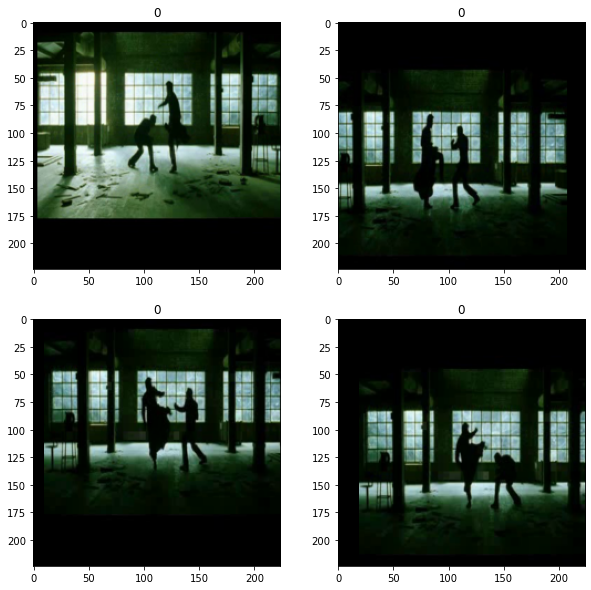

In [14]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(myutils.denormalize(img, mean, std))
    plt.title(label)

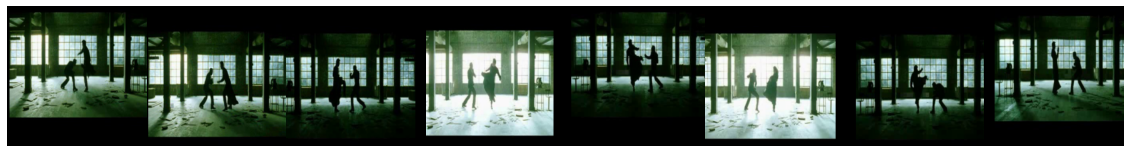

In [15]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0, hspace=0)
for ii,img in enumerate(imgs[::2]):
    plt.subplot(1,8,ii+1)
    plt.imshow(myutils.denormalize(img, mean, std))
    plt.axis("off")

In [16]:
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ]) 
test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer)
print(len(test_ds))

56


In [17]:
imgs, label = test_ds[5]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([16, 3, 224, 224]), 4, tensor(-2.1179), tensor(2.6400))

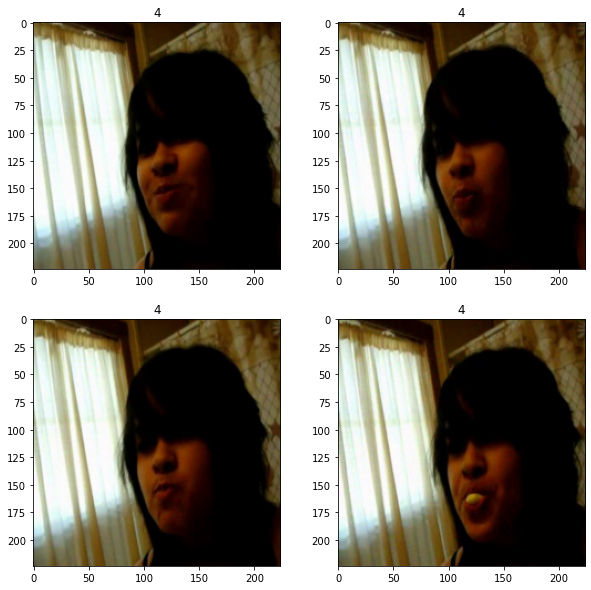

In [18]:
plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(myutils.denormalize(img, mean, std))
    plt.title(label)

## Defining Data Loaders

In [19]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor
    

batch_size = 1
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size,
                         shuffle=False, collate_fn= collate_fn_rnn)  
else:
    train_dl = DataLoader(train_ds, batch_size= batch_size, 
                          shuffle=True, collate_fn= collate_fn_r3d_18)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size, 
                         shuffle=False, collate_fn= collate_fn_r3d_18)          

In [20]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([1, 16, 3, 224, 224]) torch.Size([1])


In [21]:
for xb,yb in test_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([2, 16, 3, 224, 224]) torch.Size([2])


## Defining Model

In [22]:
from torch import nn
class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnt18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        
        baseModel = models.resnet18(pretrained=pretrained)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1])
        out = self.fc1(out) 
        return out 
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x    

In [23]:
from torchvision import models
from torch import nn

if model_type == "rnn":
    params_model={
        "num_classes": num_classes,
        "dr_rate": 0.1,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 100,}
    model = Resnt18Rnn(params_model)        
else:
    model = models.video.r3d_18(pretrained=True, progress=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

In [24]:
with torch.no_grad():
    if model_type=="rnn":
        x = torch.zeros(1, 16, 3, h, w)
    else:
        x = torch.zeros(1, 3, 16, h, w)
    y= model(x)
    print(y.shape)

torch.Size([1, 5])


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [26]:
model

Resnt18Rnn(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [27]:
path2weights = "./models/weights.pt"
torch.save(model.state_dict(), path2weights)

## Training Model

In [28]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=3e-5)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)
os.makedirs("./models", exist_ok=True)

params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": test_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": "./models/weights_"+model_type+".pt",
    }
model,loss_hist,metric_hist = myutils.train_val(model,params_train)

Epoch 0/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.003187, dev loss: 0.056023, accuracy: 0.00
----------
Epoch 1/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003796, dev loss: 0.059960, accuracy: 0.00
----------
Epoch 2/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.002934, dev loss: 0.056230, accuracy: 1.79
----------
Epoch 3/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.003589, dev loss: 0.055620, accuracy: 0.00
----------
Epoch 4/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.002945, dev loss: 0.054677, accuracy: 0.00
----------
Epoch 5/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003567, dev loss: 0.060240, accuracy: 0.00
----------
Epoch 6/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003465, dev loss: 0.055821, accuracy: 0.00
----------
Epoch 7/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003213, dev loss: 0.058982, accuracy: 0.00
----------
Epoch 8/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003267, dev loss: 0.054985, accuracy: 1.79
----------
Epoch 9/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.002913, dev loss: 0.051744, accuracy: 0.00
----------
Epoch 10/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003314, dev loss: 0.056457, accuracy: 0.00
----------
Epoch 11/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.002910, dev loss: 0.056693, accuracy: 1.79
----------
Epoch 12/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.002776, dev loss: 0.052266, accuracy: 0.00
----------
Epoch 13/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003535, dev loss: 0.056869, accuracy: 0.00
----------
Epoch 14/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.002839, dev loss: 0.056737, accuracy: 1.79
----------
Epoch 15/99, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch    16: reducing learning rate of group 0 to 1.5000e-05.
Loading best model weights!
train loss: 0.003431, dev loss: 0.055864, accuracy: 1.79
----------
Epoch 16/99, current lr=1.5e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003023, dev loss: 0.057895, accuracy: 0.00
----------
Epoch 17/99, current lr=1.5e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003641, dev loss: 0.060249, accuracy: 0.00
----------
Epoch 18/99, current lr=1.5e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003029, dev loss: 0.054227, accuracy: 1.79
----------
Epoch 19/99, current lr=1.5e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.002945, dev loss: 0.056262, accuracy: 1.79
----------
Epoch 20/99, current lr=1.5e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003204, dev loss: 0.056669, accuracy: 0.00
----------
Epoch 21/99, current lr=1.5e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch    22: reducing learning rate of group 0 to 7.5000e-06.
Loading best model weights!
train loss: 0.003817, dev loss: 0.058871, accuracy: 0.00
----------
Epoch 22/99, current lr=7.5e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003518, dev loss: 0.058969, accuracy: 1.79
----------
Epoch 23/99, current lr=7.5e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.002786, dev loss: 0.057701, accuracy: 0.00
----------
Epoch 24/99, current lr=7.5e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003374, dev loss: 0.057670, accuracy: 0.00
----------
Epoch 25/99, current lr=7.5e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003213, dev loss: 0.060304, accuracy: 0.00
----------
Epoch 26/99, current lr=7.5e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003170, dev loss: 0.055199, accuracy: 1.79
----------
Epoch 27/99, current lr=7.5e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch    28: reducing learning rate of group 0 to 3.7500e-06.
Loading best model weights!
train loss: 0.003546, dev loss: 0.057626, accuracy: 0.00
----------
Epoch 28/99, current lr=3.75e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.002878, dev loss: 0.055338, accuracy: 0.00
----------
Epoch 29/99, current lr=3.75e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.002797, dev loss: 0.056896, accuracy: 0.00
----------
Epoch 30/99, current lr=3.75e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003167, dev loss: 0.058443, accuracy: 0.00
----------
Epoch 31/99, current lr=3.75e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.002875, dev loss: 0.059404, accuracy: 0.00
----------
Epoch 32/99, current lr=3.75e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003381, dev loss: 0.057214, accuracy: 0.00
----------
Epoch 33/99, current lr=3.75e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch    34: reducing learning rate of group 0 to 1.8750e-06.
Loading best model weights!
train loss: 0.003262, dev loss: 0.059362, accuracy: 0.00
----------
Epoch 34/99, current lr=1.875e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003062, dev loss: 0.058081, accuracy: 0.00
----------
Epoch 35/99, current lr=1.875e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003706, dev loss: 0.060282, accuracy: 1.79
----------
Epoch 36/99, current lr=1.875e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003227, dev loss: 0.058178, accuracy: 1.79
----------
Epoch 37/99, current lr=1.875e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003694, dev loss: 0.061283, accuracy: 0.00
----------
Epoch 38/99, current lr=1.875e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.002725, dev loss: 0.061141, accuracy: 0.00
----------
Epoch 39/99, current lr=1.875e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch    40: reducing learning rate of group 0 to 9.3750e-07.
Loading best model weights!
train loss: 0.003358, dev loss: 0.058706, accuracy: 0.00
----------
Epoch 40/99, current lr=9.375e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003768, dev loss: 0.056167, accuracy: 0.00
----------
Epoch 41/99, current lr=9.375e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.002989, dev loss: 0.060408, accuracy: 0.00
----------
Epoch 42/99, current lr=9.375e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003046, dev loss: 0.058149, accuracy: 0.00
----------
Epoch 43/99, current lr=9.375e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003031, dev loss: 0.056338, accuracy: 1.79
----------
Epoch 44/99, current lr=9.375e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003581, dev loss: 0.061662, accuracy: 0.00
----------
Epoch 45/99, current lr=9.375e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch    46: reducing learning rate of group 0 to 4.6875e-07.
Loading best model weights!
train loss: 0.003341, dev loss: 0.059616, accuracy: 0.00
----------
Epoch 46/99, current lr=4.6875e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003050, dev loss: 0.060717, accuracy: 0.00
----------
Epoch 47/99, current lr=4.6875e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003335, dev loss: 0.054666, accuracy: 1.79
----------
Epoch 48/99, current lr=4.6875e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003370, dev loss: 0.057775, accuracy: 1.79
----------
Epoch 49/99, current lr=4.6875e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003557, dev loss: 0.057721, accuracy: 1.79
----------
Epoch 50/99, current lr=4.6875e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003640, dev loss: 0.057189, accuracy: 0.00
----------
Epoch 51/99, current lr=4.6875e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch    52: reducing learning rate of group 0 to 2.3438e-07.
Loading best model weights!
train loss: 0.003496, dev loss: 0.059843, accuracy: 0.00
----------
Epoch 52/99, current lr=2.34375e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.002918, dev loss: 0.055532, accuracy: 0.00
----------
Epoch 53/99, current lr=2.34375e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003605, dev loss: 0.057261, accuracy: 1.79
----------
Epoch 54/99, current lr=2.34375e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003318, dev loss: 0.059574, accuracy: 0.00
----------
Epoch 55/99, current lr=2.34375e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003194, dev loss: 0.059618, accuracy: 0.00
----------
Epoch 56/99, current lr=2.34375e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003315, dev loss: 0.060356, accuracy: 0.00
----------
Epoch 57/99, current lr=2.34375e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch    58: reducing learning rate of group 0 to 1.1719e-07.
Loading best model weights!
train loss: 0.002816, dev loss: 0.055946, accuracy: 0.00
----------
Epoch 58/99, current lr=1.171875e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.002882, dev loss: 0.057267, accuracy: 1.79
----------
Epoch 59/99, current lr=1.171875e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003568, dev loss: 0.058065, accuracy: 0.00
----------
Epoch 60/99, current lr=1.171875e-07


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train loss: 0.003524, dev loss: 0.058979, accuracy: 0.00
----------
Epoch 61/99, current lr=1.171875e-07


  0%|          | 0/499 [00:00<?, ?it/s]

RuntimeError: stack expects a non-empty TensorList

In [ ]:
myutils.plot_loss(loss_hist, metric_hist)